In [31]:
from sklearn.preprocessing import RobustScaler, StandardScaler
import pandas_profiling
from statsmodels.robust.scale import huber
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import re
import locale
import geopandas
plt.style.use('seaborn')
%matplotlib inline

pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)


# df_indicadores_pob = pd.read_parquet(f'../data/processed/df_indicadores_pob.parquet')
# df_final_pob = pd.read_parquet('../data/processed/df_final_pob.parquet')
# df_final_pob_melt = pd.read_parquet('../data/processed/df_final_pob_melt.parquet')
# df_final_pob_melt_PC = pd.read_parquet('../data/processed/df_final_pob_melt_PC.parquet')
# CCAA_CO = pd.read_parquet('../data/processed/CCAA_CO.parquet')
# MUNI_CO = pd.read_parquet('../data/processed/MUNI_CO.parquet')
# PROV_CO = pd.read_parquet('../data/processed/PROV_CO.parquet')



In [60]:
df_final_pob=pd.read_parquet('../data/main_processed/df_final_pob.parquet')

df_indicadores_pob=pd.read_parquet('../data/main_processed/df_indicadores_pob.parquet')

df_indicadores_pob_pivot=pd.read_parquet('../data/main_processed/df_indicadores_pob_pivot.parquet')

df_final_pob_melt=pd.read_parquet('../data/main_processed/df_final_pob_melt.parquet')

df_final_pob_melt_PC=pd.read_parquet('../data/main_processed/df_final_pob_melt_PC.parquet')

CCAA_CO = pd.read_parquet('../data/main_processed/CCAA_CO.parquet')
MUNI_CO = pd.read_parquet('../data/main_processed/MUNI_CO.parquet')
PROV_CO = pd.read_parquet('../data/main_processed/PROV_CO.parquet')

df_final_pob_dropdown=pd.read_parquet('../data/main_processed/df_final_pob_dropdown.parquet')

df_final_pob_dropdown_c=pd.read_parquet('../data/main_processed/df_final_pob_dropdown_c.parquet')

df_final_pob_poblaciontext=pd.read_parquet('../data/main_processed/df_final_pob_poblaciontext.parquet')


# %%timeit

In [61]:
CCAA_types='Andalucía'
municipio_types= 'Sevilla'
cohorte='1.000-2.000'
partida_de_coste_types='Abastecimiento de agua potable'

In [62]:
cols = df_final_pob.columns.tolist()
# cols = cols[3:48] + cols[49:51]
cols =  cols[51:95] 


df_final_pob2=df_final_pob[cols]
# df_final_pob2=df_final_pob2.drop(columns=['Código Ente Principal','Nombre Ente Principal'])


In [63]:
df_final_pob2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4869 entries, 0 to 4868
Data columns (total 44 columns):
 #   Column                                                                               Non-Null Count  Dtype  
---  ------                                                                               --------------  -----  
 0   PC_Abastecimiento de agua potable                                                    4869 non-null   float64
 1   PC_Abastos, mercados, lonjas                                                         4869 non-null   float64
 2   PC_Acceso a los núcleos de población                                                 4869 non-null   float64
 3   PC_Actividades funerarias                                                            4869 non-null   float64
 4   PC_Alcantarillado                                                                    4869 non-null   float64
 5   PC_Alumbrado público                                                                 4869 

In [64]:
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_rescaled = scaler.fit_transform(df_final_pob)

rs = StandardScaler()
data_rescaled  = pd.DataFrame(rs.fit_transform(df_final_pob2), columns= df_final_pob2.columns)

#data_rescaled

In [65]:
import umap

reducer = umap.UMAP(random_state=42,
                    n_neighbors=15,
                    min_dist=0.1,
                    n_components=2,
                    metric='euclidean')
reducer.fit(data_rescaled)

embedding = reducer.transform(data_rescaled)

embedding.shape



(4869, 2)

In [111]:
import hdbscan

hdbscan_c = hdbscan.HDBSCAN(min_cluster_size=129)

hdbscan_c.fit(embedding)

hdbscan_c

HDBSCAN(min_cluster_size=129)

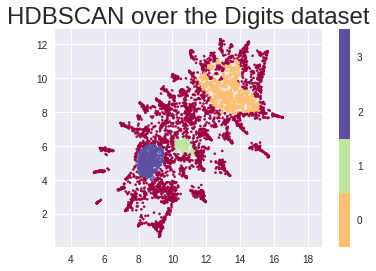

In [112]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=hdbscan_c.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(np.unique(hdbscan_c.labels_)) + 1) - 0.5).set_ticks(np.arange(len(np.unique(hdbscan_c.labels_))))
plt.title('HDBSCAN over the Digits dataset', fontsize=24);

In [118]:
from sklearn.cluster import DBSCAN

dbscan_c = DBSCAN(eps=1, min_samples=129).fit(embedding)

dbscan_c

DBSCAN(eps=1, min_samples=129)

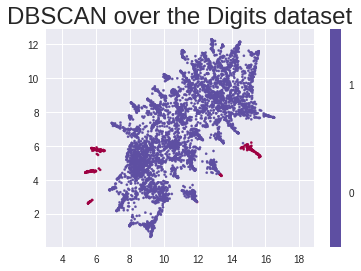

In [119]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=dbscan_c.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(np.unique(dbscan_c.labels_)) + 1) - 0.5).set_ticks(np.arange(len(np.unique(dbscan_c.labels_))))
plt.title('DBSCAN over the Digits dataset', fontsize=24);

In [120]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4,random_state=42).fit(embedding)

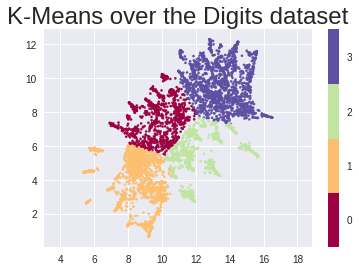

In [121]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(kmeans.n_clusters + 1) - 0.5).set_ticks(np.arange(kmeans.n_clusters))
plt.title('K-Means over the Digits dataset', fontsize=24);

In [122]:
df_final_pob['cluster']=hdbscan_c.labels_

In [123]:
df_final_pob['cluster'].value_counts()

-1    3539
 0     716
 2     479
 1     135
Name: cluster, dtype: int64

In [125]:
cols = df_final_pob.columns.tolist()
cols = cols[0:5] + cols[49:]

df_final_pob3=df_final_pob[cols]

df_final_pob3=df_final_pob3.drop(columns=['codigo_geo'])

cols = df_final_pob3.columns.tolist()
cols4 = cols[0:7] + cols[50:] + cols[8:18]
cols5= cols[0:7] + cols[50:] + cols[18:28]
cols6= cols[0:7] + cols[50:] + cols[28:38]
cols7= cols[0:7] + cols[50:] + cols[38:50]


df_final_pob4=df_final_pob3[cols4]
df_final_pob5=df_final_pob3[cols5]
df_final_pob6=df_final_pob3[cols6]
df_final_pob7=df_final_pob3[cols7]


df_final_pob4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4869 entries, 0 to 4868
Data columns (total 20 columns):
 #   Column                                                                               Non-Null Count  Dtype   
---  ------                                                                               --------------  -----   
 0   CCAA                                                                                 4869 non-null   category
 1   Provincia                                                                            4869 non-null   category
 2   Tipo Ente Principal                                                                  4869 non-null   category
 3   Nombre Ente Principal                                                                4869 non-null   category
 4   Código Ente Principal                                                                4869 non-null   category
 5   Población 2018                                                                     

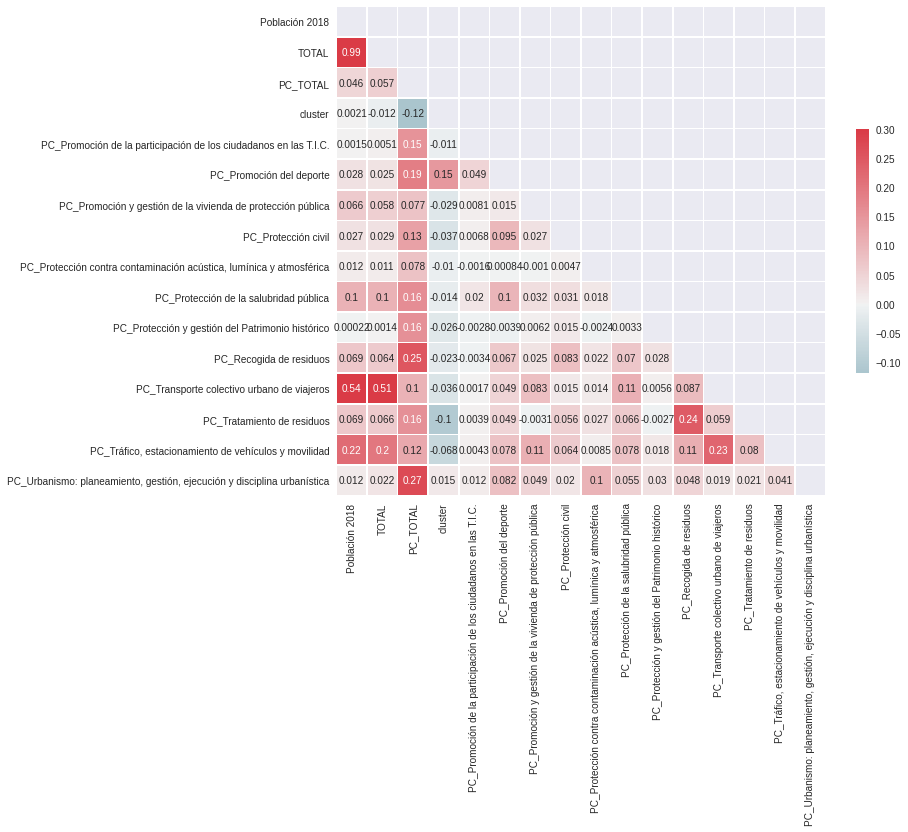

In [126]:
df=df_final_pob7
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [127]:
df_final_pob[['Población 2018','PC_TOTAL', 'cohorte_pob','cluster']]

df=df_final_pob[['Población 2018','PC_TOTAL', 'cohorte_pob','cluster']].loc[df_final_pob['Población 2018']<5000]
df['cluster'] = df['cluster'].astype('category')

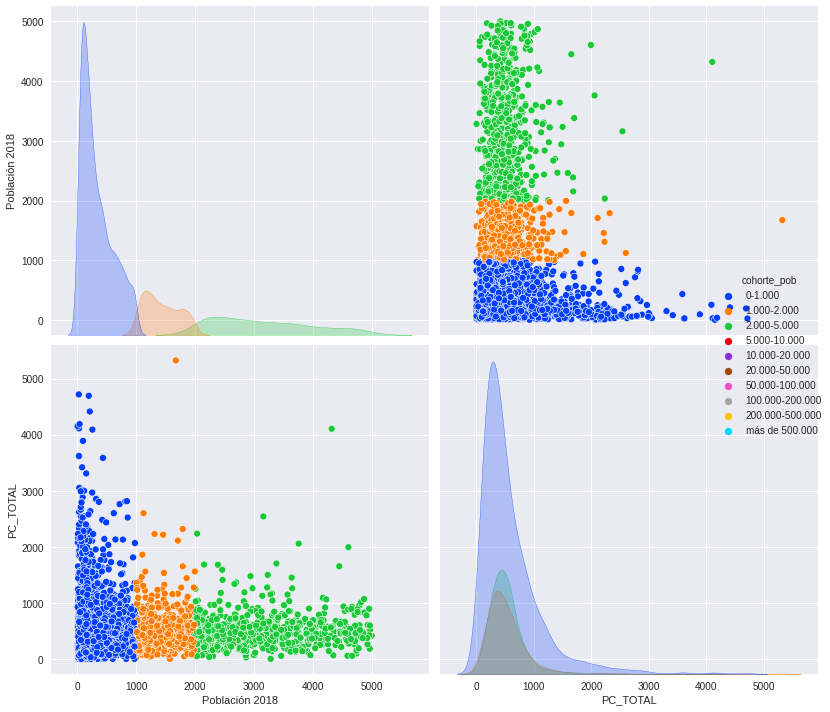

In [128]:




# sns.set(font_scale=1.4)
sns.pairplot(df[['Población 2018','PC_TOTAL', 'cohorte_pob']],hue='cohorte_pob',height=5,palette='bright', diag_kind='kde')
plt.tight_layout()
plt.show()

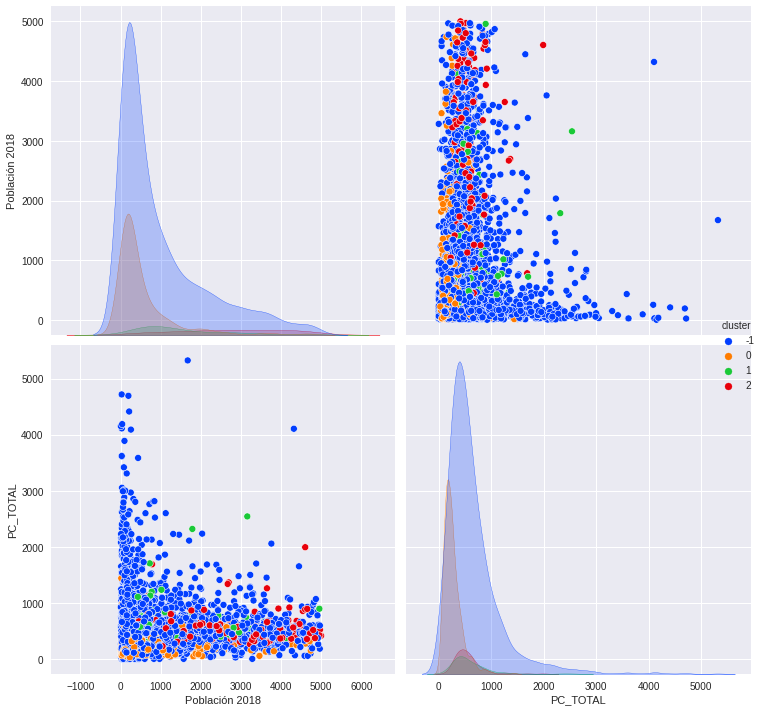

In [129]:
sns.pairplot(df[['Población 2018','PC_TOTAL', 'cluster']],hue='cluster',height=5,palette='bright', diag_kind='kde')
plt.tight_layout()
plt.show()

In [84]:
cols = df_final_pob.columns.tolist()
# cols = cols[3:48] + cols[49:51]
cols = cols[3:5] + cols[51:95] 


# df_final_pob2=df_final_pob2.drop(columns=['Código Ente Principal','Nombre Ente Principal'])


df_final_pob5=df_final_pob[cols]

# df_final_pob5.profile_report()

In [140]:
df_n = df_final_pob_melt.pivot_table(index=['Descripción'] , values=['coste_efectivo'] , aggfunc=sum).sort_values(
            by='coste_efectivo' , ascending=False).reset_index()
div = df_final_pob['Población 2018'].sum()
df_n['coste_efectivo_new'] = round(df_n['coste_efectivo'] / div , )

df_c= df_final_pob_melt.pivot_table(index=['CCAA' , 'Descripción'] , values=['coste_efectivo'] ,
                    aggfunc=sum).sort_values(by='coste_efectivo' , ascending=False).reset_index()


df = df_n

df2 = df_c

div = df_final_pob.loc[df_final_pob['CCAA'] == CCAA_types , 'Población 2018'].sum()
df2 = df2.loc[df2['CCAA'] == CCAA_types]
df2['coste_efectivo_new'] = round(df2['coste_efectivo'] / div,)
partida_de_coste_types='Abastecimiento de agua potable'


colors = ['rgb(55, 83, 109)'] * df2['Descripción'].shape[0]

df2['Descripción'].to_list()
for pos,item in enumerate(df2['Descripción'].to_list()):
    if item==partida_de_coste_types:
        colors[pos] = 'crimson'


colors




/home/carpiero/miniconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


['rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'crimson',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)',
 'rgb(55, 83, 109)']

In [166]:


strng="fook5585464bar001"

hello=[]
for x in strng:
        hello.append(x)


hello[-1]='popo'


hello

['f',
 'o',
 'o',
 'k',
 '5',
 '5',
 '8',
 '5',
 '4',
 '6',
 '4',
 'b',
 'a',
 'r',
 '0',
 '0',
 'popo']

In [168]:
y= re.findall(r'\.+0*' , strng)
print(y)





[]


In [12]:
labels=['0-1.000','1.000-2.000','2.000-5.000','5.000-10.000','10.000-20.000',
                                          '20.000-50.000','50.000-100.000','100.000-200.000','200.000-500.000','más de 500.000']

In [206]:
partida_de_coste_types=df_final_pob_melt_PC['Descripción'].unique().to_list()

item=[]
for y in partida_de_coste_types:
    for x in labels:
        df = df_final_pob_melt_PC.loc[(df_final_pob_melt_PC['cohorte_pob'] == x)  & (df_final_pob_melt_PC['Descripción'] == y)]
#         item.append(list(df.loc[df['coste_efectivo_PC'] == df['coste_efectivo_PC'].quantile(0.76 , interpolation='nearest'),'Nombre Ente Principal'])[0])
#         item.append(list(df.loc[df['coste_efectivo_PC'] == df['coste_efectivo_PC'].quantile(0.53 , interpolation='nearest'),'Nombre Ente Principal'])[0])
#         item.append(list(df.loc[df['coste_efectivo_PC'] == df['coste_efectivo_PC'].quantile(0.22 , interpolation='nearest'),'Nombre Ente Principal'])[0])
        print(list(df.loc[df['coste_efectivo_PC'] == df['coste_efectivo_PC'].quantile(0.76 , interpolation='nearest'),'Nombre Ente Principal'])[0])
        print(list(df.loc[df['coste_efectivo_PC'] == df['coste_efectivo_PC'].quantile(0.53 , interpolation='nearest'),'Nombre Ente Principal'])[0])
        print(list(df.loc[df['coste_efectivo_PC'] == df['coste_efectivo_PC'].quantile(0.22 , interpolation='nearest'),'Nombre Ente Principal'])[0])

        
# dum=0
# for x in item:
#     dum+=len(x)
    
# print(dum)
        
        
        

Palomar (el)
Herguijuela de Ciudad Rodrigo
Valverde de Burguillos
Láujar de Andarax
Grañén
Merca (A)
Ampuero
Carballedo
Moraña
Olleria (l')
Mugardos
Álamo (El)
Medina-Sidonia
Aller
Barco de Valdeorras (O)
Masnou (El)
Úbeda
Pájara
Lorca
Mérida
Segovia
Huelva
Badajoz
Fuenlabrada
Vigo
Elche/Elx
Valladolid
Sevilla
Zaragoza
Madrid
Mondariz-Balneario
Godall
Jarafuel
Láujar de Andarax
Lahiguera
Coripe
Balanegra
Campanario
Villablanca
Selva del Camp (La)
Paradas
Caldas de Reis
Ubrique
Cocentaina
Guadix
Don Benito
Vilafranca del Penedès
Langreo
Ávila
Rubí
Lorca
Reus
Burgos
Dos Hermanas
Granada
Vigo
Elche/Elx
Barcelona
Sevilla
Zaragoza
Garcia
Oliete
Almarza
Rioja
Riudecols
Relleu
Coronada (La)
Molina de Aragón
Villanueva del Fresno
Palafolls
Torreperogil
Bellpuig
Santa Marta de Tormes
Ciudad Rodrigo
Meliana
Sant Josep de sa Talaia
Castellar del Vallès
Ribeira
Arganda del Rey
Huesca
Torrent (Valencia)
Telde
Alcobendas
Lleida
Elche/Elx
Sabadell
Oviedo
Barcelona
València
Madrid
Palenzuela
Arnedillo